# Probabilistic Linear Discriminant Analysis

PLDA is supervised learning. In PLDA assumes that the training data can be generated by known process (given by equation). Therfore it is called a generative model because of that. The PLDA instead of work with distances as measures of similarity, it provides probabilities as measure of similarity. Like in Fisher LDA, PLDA transform the training data into a new space where the discriminativy power is maximized. Beloow are the main assumpiosn:

1. Normal distribution
    * All classes are normal distributed: $P(x \mid y) = N(x \mid y,\Phi_w)$
    * All class has the same covariance matrix $\Phi_w$ 
    * The centroides of each class are normal distributed: $P(y) = N(y|m,\Phi_b)$. Therefore, PLDA can be extended to unknown classes.
3. Each class has the same number of samples $n_k$ (For analytic soltuion, but not for EM solution). Case it is not true, resample the class in order to have all class with the same number of observations or set $n_k$ with average number of sample per class

The solution has the constraints:
1. $\Phi_w$ is positive defined
2. The priori $P(y) = N(y \mid 0,\Phi_b)$ is normal distributed
3. $\Phi_b$ is semi-positive defined

See this wiki: [this](https://en.wikipedia.org/wiki/Positive-definite_matrix)

Motivations:

refs: https://ravisoji.com/assets/papers/Ioffe2006PLDA.pdf (abstract)

1. Fisher LDA is common used in object recognition for feature extraction, but do not address the problem of how to use these features for recognition.
2. The latent variables of PLDA (PLDA components) represent both: the class of the object and the within variability class of the object.
3. Automatic give more weight of the features with the most discriminativy power
4. Can build a model of unseen class with only one example or can combine multiple examples for a better representation of the class

Application:


It is commonly used in biometric authentication and PLDA models are the best performance for face and speaker recognition

* Speaker recognition
* Face recogintion

For simplicity, the practical aspect of PLDA will be explained utilzing 3 classes example and bi-dimensional data.

###  How PLDA works

The dataset is a set of $n$ d-dimensional samples $X = \{x_1, x_2, ..., x_n\}$ already labeled in 2 groups: 
$X^{(k)} = \{ x_1^{(k)},  x_2^{(k)}, ..., x_{n_k}^{(k)} \}$ of size $n_k$ for $k = 1,2, ..., K$ where $x_i^{(k)}$ is a vector of dimension $d$ and mean the ith sample of the kth class.

The figure below an labeled dataset ($x_i^{(k)}$) contained 3 classes are shown.  The centroides of each class $y = m_k$ can be seen in red.

<img src="../images/plda_0.png" width="300"/>

The linear transformation $x' = W^t x$ map $x_i^{(k)}$ in to new set of axis defined by the new subsace $U$ where all class follows standart multivariate normal distribution. And the centroides follows a multivariate normal distribution where the covariance matrix is decorrelated.

<img src="../images/plda_1.png" width="300"/>


PLDA assumes that the traiining data is generated by:

$
x = m + Au
$

and the centroids by

$
y = m + Av
$

The subsace define by $U$ space maximize the discriminativy power. In order to do that, PLDA like Fisher LDA maximize the ratio "scattter between classes/scatter within classes" 
expressed by the cost function $J(w)$ by solving the gerenalized eigenvector eigenvalue problem

$
S_b w =  \lambda S_w w
$

where:

$\boldsymbol W = \begin{bmatrix}
 w_1 & w_2 & \cdots & w_k
\end{bmatrix} 
$

* $S_b= \frac{1}{N} \sum_{k=1^K} n_k (m_k - m)( m_k - m)^t$ :  between-class covariance/satter matrix. (Can be understood as measure of between class spread)
    
* $S_{w} = \frac{1}{N} \sum_{k=1^K} S_k$ : within-class covariance/scatter matrices. (Can be understood as measure of within class spread or the sum of the spread matrix of each class) 

$ m_k$ is the mean of each class. $m$ is the global mean. and $S_k$ is the spread matrix of each class giben by:

$
S_k = \sum_{x_i\in X^{(k)}} ( x_i^{(k)} -  m_k) ( x_i^{(k)} - m_k)^t  
$

The spread matrix are related to the covariance matrx by the equation:

$
\Sigma_k = \frac{1}{N_k -1}S_k  
$

$
J(w) = \frac{w^t S_{b} w}{ w^t S_{w}  w}
$

=============================

Transforms an X into a space where the within-class variance is unit and between-class variance is diagonalized.

The probability of not belonging to any known class is: 

P(u_new| 0) = N(u_new| 0, \Psi + I)


### Summarizing the LDA approach in 5 steps

1. Compute Fisher LDA parameters 
2. Update parameters 
    * between-class: measure of dispersion between groups or classes
    * within-class scatter matrix: measure of dispersion in the class or group
3. Reduce dimensionality



In [95]:
import numpy as np
from scipy.linalg import eigh

import pandas as pd
import random as rand
import math
import matplotlib.pyplot as plt

np.set_printoptions(precision=4)

from scipy.stats import multivariate_normal

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline

In [96]:
import sys
sys.path.append('/Users/leandro/Documents/leandro/studies/lda/refs/plda')

import plda

load data

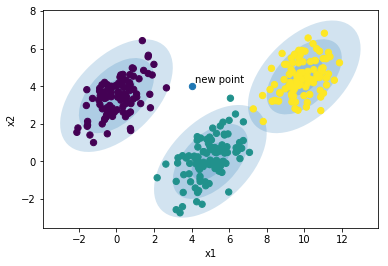

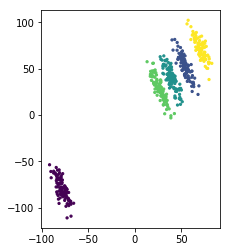

(500, 3)

array([0, 1, 2, 3, 4])

500

100

,x,y,label
419,70.666011,71.299763,4
98,-78.912518,-80.436834,0
235,49.556942,28.715026,2
421,74.141707,60.310675,4
166,47.121866,62.181778,1


In [47]:
%run ../simulated_plda_data.ipynb

df.shape

X = df[['x','y']].values
N = X.shape[0]
y = df.label

df.label.unique()

X1 = df.loc[df.label ==1,['x','y']].values
nk = X1.shape[0]

N
nk

df.sample(5).head(5)

In [70]:
def estimate_gaussian_parameters(Xk):

    mk = np.mean(Xk,axis=0)
    Sk = np.cov(Xk[:,0],Xk[:,1])
    
    return mk, Sk

def get_plda_paramaters(Xk,N):
    
    Nk = Xk.shape[0]
    
    pik = Nk/N
    
    mk, Sk = estimate_gaussian_parameters(Xk)
    
    Sk_inv = np.linalg.inv(Sk)
    
    return Sk_inv, pik

def lda_score(X_new,mk, Sk,Sk_inv, pik):
    
    scorek = -0.2*np.log(np.linalg.det(Sk)) 
    uk = X_new - mk
    Ak = np.matmul(Sk_inv,uk.T)
    scorek = scorek - 0.5*np.matmul(uk,Ak) 
    scorek += np.log(pik)
    
    return scorek

def compute_scatter_matrixes(X,y,labels,nk):
    
    d = X.shape[1]
    N = X.shape[0]
    
    m = np.mean(X,axis=0)
    
    Sw = np.zeros((d,d))
    Sb = np.zeros((d,d))
    
    for label in labels:
    
        Xk = np.squeeze(X[np.argwhere(y == label)])
        mk, Sk = estimate_gaussian_parameters(Xk)
        
        # within spread matrix
        Sw = np.add(Sw,(nk -1)*Sk/N)
        
        # between spread matrix
        dmk = np.add(mk,-m)
        dmk = dmk[np.newaxis].transpose()

        Sb = np.add(Sb, nk/N*np.matmul(dmk, dmk.transpose()))
    
    return Sw, Sb
    
def diagnolize_matrix(M, W):
    
    M_diag = np.matmul(W.T,np.matmul(M,W))
    M_diag = np.diag(M_diag.diagonal())
    
    return M_diag
    
def compute_transformation_matrix(Sw,Sb,nk):
    
    Sw_inv = np.linalg.inv(Sw)
    d = Sw.shape[0]
     
    S = np.matmul(Sw_inv, Sb)
    
   
    # XXX solves the generalized eigenvalue problem:
    # Av = \lambda Bv where B is positive definite (numpy eigh does not have this constraint).
    # But I understood that \Phi_w is positive definte n Phi_b semi positive definite and
    # not Sw !?
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.eigh.html
    # Wtih numpy eigh is not working 
    eigenvalues, W = eigh(Sb, Sw)
    #eigen_values, W = np.linalg.eigh(S)
        
    # projected/diagnolized within spread matrix: projecting Sw
    Lambda_w = diagnolize_matrix(Sw,W)
  
    weight = nk/(nk - 1)
    
    Lambda_w_weighted = weight*Lambda_w
    # prevent small negative numbers due to numerical error
    Lambda_w_weighted[np.isclose(Lambda_w_weighted, 0.0)] = 0.0
    Lambda_w_weighted = np.sqrt(Lambda_w_weighted)
    
    W_transposed_inv = np.linalg.inv(W).T
    
    A = np.matmul(W_transposed_inv, Lambda_w_weighted)
    
    return A, W

def compute_transformed_between_covariance(Lambda_w,Lambda_b,nk):
    
    weight = (nk - 1)/nk
    
    with np.errstate(divide='ignore', invalid='ignore'):
         Psi_diagonal = weight * Lambda_b.diagonal() / Lambda_w.diagonal()

    Psi_diagonal[np.isnan(Psi_diagonal)] = 0.0
    Psi_diagonal = Psi_diagonal - 1.0/nk
    
    # max(0, Psi)
    Psi_diagonal[Psi_diagonal < 0.0] = 0.0
    
    Psi_diagonal[np.isinf(Psi_diagonal)] = 0.0
    Psi = np.diag(Psi_diagonal)

    return Psi


def plda_fit(X, y):
   
    N = X.shape[0]
    K = np.size(np.unique(y)) #labels.nunique()
    labels = np.unique(y)
    nk = N/K
    
    global_mean = np.mean(X,axis=0)
    
    Sw, Sb = compute_scatter_matrixes(X,y,labels,nk)
    
    A, W = compute_transformation_matrix(Sw,Sb,nk)
    
    Lambda_w = diagnolize_matrix(Sw,W)
    Lambda_b = diagnolize_matrix(Sb,W)
    
    print(Lambda_w)
    print(Lambda_b)
    
    # The within trasnformed covariance is Identity matrix
    Psi = compute_transformed_between_covariance(Lambda_w,Lambda_b,nk)
   
    return global_mean, A, Psi

In [49]:
classifier = plda.Classifier(X, y)
classifier.fit_model()

In [50]:
Sw,Sb = compute_scatter_matrixes(X,y,y.unique(),nk)

Sw
classifier.model.S_w

Sb
classifier.model.S_b

array([[ 28.9906, -52.5728],
       [-52.5728, 139.6685]])

array([[ 28.9906, -52.5728],
       [-52.5728, 139.6685]])

array([[2779.8685, 2788.6271],
       [2788.6271, 2798.6723]])

array([[2779.8685, 2788.6271],
       [2788.6271, 2798.6723]])

In [51]:
from scipy.linalg import eigh

vals, W2 = eigh(Sb, Sw)
W2



Sw_inv = np.linalg.inv(Sw)
d = Sw.shape[0]
     
S = np.matmul(Sw_inv, Sb)
eigen_values, W = np.linalg.eigh(S)
W


array([[-0.0606,  0.324 ],
       [ 0.0604,  0.1375]])

array([[ 0.4689, -0.8833],
       [-0.8833, -0.4689]])

In [52]:
A, W = compute_transformation_matrix(Sw,Sb, nk)

W
class_W = classifier.model.calc_W(Sb, Sw)
class_W

A
class_Lambda_w = classifier.model.calc_Λ_w(Sw, W)
class_A = classifier.model.calc_A(nk, class_Lambda_w, class_W)
class_A

array([[-0.0606,  0.324 ],
       [ 0.0604,  0.1375]])

array([[-0.0606,  0.324 ],
       [ 0.0604,  0.1375]])

array([[-4.9549,  2.1753],
       [11.6755,  2.1824]])

array([[-4.9549,  2.1753],
       [11.6755,  2.1824]])

In [16]:
Lambda_w = diagnolize_matrix(Sw,W)
Lambda_b = diagnolize_matrix(Sb,W)

Psi = compute_transformed_between_covariance(Lambda_w,Lambda_b,nk)

print('Lambdas')
Lambda_w
Lambda_b

Phi_w = np.matmul(A,A.T)
Phi_b = np.matmul(A,np.matmul(Psi,A.T))

print('Phis')
Phi_w
Phi_b

Psi

Lambdas


array([[1., 0.],
       [0., 1.]])

array([[4.5893e-03, 0.0000e+00],
       [0.0000e+00, 5.9338e+02]])

Phis


array([[ 29.2834, -53.1038],
       [-53.1038, 141.0793]])

array([[2779.7096, 2788.8425],
       [2788.8425, 2798.0053]])

array([[  0.    ,   0.    ],
       [  0.    , 587.4408]])

In [20]:
print('Phiw vs Sw')
Phi_w 
(nk/(nk -1)*Sw)

print('Phib vs Sb')
Phi_b 
Sb - 1.0/(nk-1)*Sw


Phiw vs Sw


array([[ 29.2834, -53.1038],
       [-53.1038, 141.0793]])

array([[ 29.2834, -53.1038],
       [-53.1038, 141.0793]])

Phib vs Sb


array([[2779.7096, 2788.8425],
       [2788.8425, 2798.0053]])

array([[2779.5757, 2789.1581],
       [2789.1581, 2797.2615]])

In [21]:
m, A, Psi = plda_fit(X, y)

m
A
Psi

[[1. 0.]
 [0. 1.]]
[[4.5893e-03 0.0000e+00]
 [0.0000e+00 5.9338e+02]]


array([22.6366, 22.3433])

array([[-4.9549,  2.1753],
       [11.6755,  2.1824]])

array([[  0.    ,   0.    ],
       [  0.    , 587.4408]])

In [22]:
## double check transformations

u1 = np.matmul(W.T,x_new)

A_inv = np.linalg.inv(A)

u2 = np.matmul(A_inv,x_new - m)

np.dot(u1,u2)

np.matmul(u1,u2.T)

# u1 n u2 are orthogonal


np.arccos(np.matmul(u1/np.linalg.norm(u1),u2.T/np.linalg.norm(u2)))/np.pi

-15.728339151857178

-15.728339151857178

0.9993410648387023

In [23]:
St = (N - 1.0)* np.cov(X[:,0],X[:,1])

u = np.add(X,-m).transpose()
S_hat = np.matmul(u,u.transpose())

St - S_hat

N*Sw + N*Sb

St

S_hat

array([[ 0.0000e+00,  0.0000e+00],
       [ 0.0000e+00, -2.3283e-10]])

array([[1404429.5325, 1368027.1627],
       [1368027.1627, 1469170.408 ]])

array([[1404429.5325, 1368027.1627],
       [1368027.1627, 1469170.408 ]])

array([[1404429.5325, 1368027.1627],
       [1368027.1627, 1469170.408 ]])

## Predict

In [120]:
def project_data(z, M_inv,global_mean):
    
    z_transformed = np.matmul(M_inv,(z - global_mean).T)
    
    return z_transformed

def plda_predict(X_new,X, y,A_inv, Psi, nk):
    
    I = np.identity(Psi.shape[0]).diagonal()
    
    global_mean = np.mean(X,axis=0)
    
    # u' = A^{-1}(x - m)
    U_new = project_data(X_new,A_inv,global_mean)
    
    #print(X_new.shape)
    
    prob_max = -np.Infinity
    label_max = -1
    labels = np.unique(y)
    
    Psi_diag = Psi.diagonal()
    
    for label in labels:
        
        print('label: {}'.format(label))
        
        Xk = np.squeeze(X[np.argwhere(y == label)])
        #print(Xk.shape)
        print('mk: {}'.format(Xk.mean(axis=0)))
        
        U_g = project_data(Xk,A_inv,global_mean)
        U_g = U_g.T
        #print(U_g.shape)
        
        u_g_mean = U_g.mean(axis=0)
        #print(u_g_mean.shape)
      
        with np.errstate(divide='ignore', invalid='ignore'):
            
            mu_g = nk*Psi_diag/(nk*Psi_diag + I)
            mu_g = np.diag(mu_g)
            mu_g = np.matmul(mu_g,u_g_mean)
            
            #print('mu_g')
            #print(mu_g)
            #print(mu_g.shape)
  
        
            Sg = I + Psi_diag/(nk*Psi_diag + I)
            Sg = np.diag(Sg)
            
            #print('Sg')
            #print(Sg)
            #print(Sg.shape)
        
        m_normal = multivariate_normal(mean=mu_g, cov=Sg)
        
        prob = m_normal.pdf(U_new)
        
        print('prob: {}'.format(prob))
        
        if prob > prob_max:
            prob_max = prob
            label_max = label
        
    return label_max, prob_max

In [132]:
X_new = np.array([100.0,80.0])

X_new
X.shape
y.unique()
A_inv
Psi
nk

y_new, prob = plda_predict(X_new, X, y, A_inv, Psi, nk)

print('New label')
y_new
prob


array([100.,  80.])

(500, 2)

array([0, 1, 2, 3, 4])

array([[-0.0107, -0.0331],
       [ 0.0391, -0.068 ]])

array([[11.3334,  0.    ],
       [ 0.    , 95.8518]])

100

label: 0
mk: [-78.5916 -79.4483]
prob: 8.08681339050223e-16
label: 1
mk: [54.3726 52.1359]
prob: 0.05846094755073446
label: 2
mk: [39.4421 39.732 ]
prob: 0.021119995155479864
label: 3
mk: [26.9044 27.8456]
prob: 0.005544851013589819
label: 4
mk: [71.0554 71.4513]
prob: 0.1139182417431353
New label


4

0.1139182417431353

## Verification of the equations on the first sections

For the verification of the formulas cited in the firsts sections (See: [Small discussion about how LDA works (Can be skipped)]()), we are going to compute all matrix: $\hat{\Sigma_1}$, $\hat{\Sigma_2}$ and $S_t$ and compare with the global covariance matrix of the data (the spread of the data conserves) $\hat{\Sigma}$. Also because we generated the data using two multivariate Gaussians, we know the true values of the parameters $\Sigma_1$ and $\Sigma_2$ and we can compare with our estimations of this parameters.

* Estimating the covariances Matrix

Computing $\hat{\Sigma_k}$ and comparing with the true values $\Sigma_k$


array([[11.3334,  0.    ],
       [ 0.    , 95.8518]])

array([-4.,  1.])

V


(3, 2)

array([[ 1.3112,  5.9898],
       [-1.2001, -0.3257],
       [-0.1111, -5.6641]])

U
mk: [1.3112 5.9898]
uk.mean: [1.3016 5.882 ]
mk: [-1.2001 -0.3257]
uk.mean: [-1.2156 -0.1515]
mk: [-0.1111 -5.6641]
uk.mean: [-0.0355 -5.6097]


(300, 2)

array([0.0168, 0.0403])

(array([ 1.,  4.,  6., 12., 19., 22., 11., 16.,  6.,  2.]),
 array([-8.3442, -7.8336, -7.323 , -6.8124, -6.3018, -5.7911, -5.2805,
        -4.7699, -4.2593, -3.7487, -3.2381]),
 <a list of 10 Patch objects>)

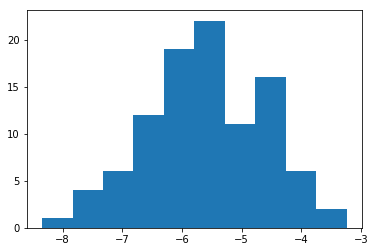

In [34]:
from numpy.random import multivariate_normal
def gen_Psi():
    """ Diagonal matrix describing the covariance between clusters.
    """
    np.random.seed(2018)
    d = 2
    Psi = np.diag(10.0/np.random.sample(d))

    return Psi

def gen_global_mean():
    
    d = 2
    m = np.random.randint(-10.0, 10.0, d).astype(float)
    
    return m

def gen_V_space(Psi):
    # v ~ N(v|0,Psi)

    n_class = 3
    d = Psi.shape[0]
    
    V = multivariate_normal(np.zeros(d),Psi,n_class)
    V = V - V.mean(axis=0)
    
    return V
    
def gen_U_space(V):
     # u ~ N(u|v,1)
    
    n_class = V.shape[0]
    d = V.shape[1]
    
    nk = 100

    U = []
    for k in range(0,n_class):
        
        mk = V[k,:]
        print('mk: {}'.format(mk))
        uk = multivariate_normal(mk,np.diag([1.0 , 1.0]),nk)
        print('uk.mean: {}'.format(uk.mean(axis=0)))
        U.append(uk)
    
    
    U = np.vstack(U)
    return U 


def gen_A(V):
    """ A = [B][inv(Λ ** .5)][Q^T] and assumes same number of data
             in each class v. 
    """
    d = V.shape[1]
    
    np.random.seed(2018)
    B = np.random.randint(-200, 200, (d, d)).astype(float)
    
    print(B)
    
    big_V = np.matmul(V.T, V)  # V is now a scatter matrix.
    
    print('bigV')
    print(big_V)
    
    vals, vecs = np.linalg.eig(big_V)
    
    print('eigen vector values')
    print(vals)
    print(vecs)

    A = B / np.sqrt(vals.real)

    print('partial A')
    print(A)
    A = np.matmul(A, vecs.T)

    return A

Psi = gen_Psi()
Psi

m = gen_global_mean()
m

print('V')

V = gen_V_space(Psi)
V.shape

V

print('U')

U = gen_U_space(V)
U.shape

# should be ckose to zero because of V is zero mran
U.mean(axis=0)

ax = plt.gca()
ax.hist(U[201:300,1])

In [35]:
A = gen_A(V)
A

[[ 50. -98.]
 [ 26.  65.]]
bigV
[[ 3.1717  8.8735]
 [ 8.8735 68.0659]]
eigen vector values
[ 1.9802 69.2574]
[[-0.9911 -0.1331]
 [ 0.1331 -0.9911]]
partial A
[[ 35.5315 -11.7759]
 [ 18.4764   7.8105]]


array([[-33.6484,  16.3996],
       [-19.3515,  -5.2822]])

In [36]:
U_labels = ([1] * 100) + ([2] * 100) + ([3] * 100)
y = np.array(U_labels)

Phi_w = np.matmul(A,A.T)

nk = 100

Sw,Sb = compute_scatter_matrixes(X,y,np.unique(y),nk)


Phi_w

Sw


array([[1401.1605,  564.5188],
       [ 564.5188,  402.3814]])

array([[1410.1053,  542.8842],
       [ 542.8842,  366.7385]])

In [37]:
A_inv = np.linalg.inv(A)

np.matmul(A_inv,A)

Au =  np.matmul(A, U.T).T

Au.shape

Au.mean(axis=0)
Au.min(axis=0)
Au.max(axis=0)


X = m + Au
X.shape

X.mean(axis=0)
m

(m - X.mean(axis=0))/m

array([[1.0000e+00, 5.4103e-17],
       [2.9842e-17, 1.0000e+00]])

(300, 2)

array([ 0.0938, -0.5388])

array([-180.957 , -103.2178])

array([163.1598,  69.2848])

(300, 2)

array([-3.9062,  0.4612])

array([-4.,  1.])

array([0.0235, 0.5388])

In [38]:
# Tranformed centorid os each class (Good for verofocation)
Av =  np.matmul(A, V.T).T
Y = m + Av 
Y.shape

Y

X1 = X[0:100,:]
x_bar = np.mean(X1,axis=0)

# Comparing the true parameter Y_1 with the estimation of this parmeter
Y[0,:]
x_bar

(Y[0,:] - x_bar)/Y[0,:]

(3, 2)

array([[ 50.1119, -56.0124],
       [ 31.0402,  25.9437],
       [-93.1521,  33.0686]])

array([ 50.1119, -56.0124])

array([ 48.6672, -55.2577])

array([0.0288, 0.0135])

(-4.139122947207262, 4.038255788077333, -9.171561312485261, 8.711185541261)

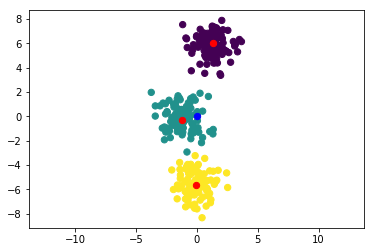

In [39]:
U_labels = ([1] * 100) + ([2] * 100) + ([3] * 100)

ax = plt.gca()
ax.scatter(U[:, 0], U[:, 1], c=U_labels, s=40, cmap='viridis', zorder=2)
ax.scatter(V[:, 0], V[:, 1], c='red', s=40, cmap='viridis', zorder=2)
ax.scatter(0, 0, c='blue', s=40, cmap='viridis', zorder=2)
ax.axis('equal')

(-202.17325461186337,
 176.3760384697844,
 -110.85887604291118,
 78.92587908445786)

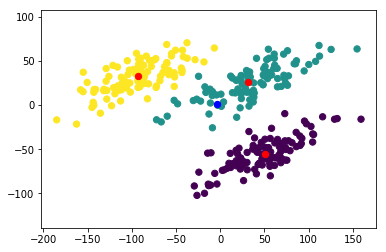

In [40]:
ax = plt.gca()
ax.scatter(X[:, 0], X[:, 1], c=U_labels, s=40, cmap='viridis', zorder=2)
ax.scatter(Y[:, 0], Y[:, 1], c='red', s=40, cmap='viridis', zorder=2)
ax.scatter(m[0], m[1], c='blue', s=40, cmap='viridis', zorder=2)
ax.axis('equal')

In [41]:
y = np.array(U_labels)

plda_m, plda_A, plda_Psi = plda_fit(X, y)

print('A')
A
plda_A

print('Psi')
Psi
plda_Psi

[[1. 0.]
 [0. 1.]]
[[ 0.7469  0.    ]
 [ 0.     23.7806]]
A


array([[-33.6484,  16.3996],
       [-19.3515,  -5.2822]])

array([[-35.8871, -11.6819],
       [-17.7234,   7.505 ]])

Psi


array([[11.3334,  0.    ],
       [ 0.    , 95.8518]])

array([[ 0.7294,  0.    ],
       [ 0.    , 23.5328]])

In [32]:
plda_Phi_w = np.matmul(plda_A,plda_A.T)
plda_Phi_w

X1 = X[0:100,:]
X2 = X[100:200,:]
X3 = X[200:300,:]

print('S1')
S1 = np.cov(X1[:,0],X1[:,1])
S1

print('S2')
S2 = np.cov(X2[:,0],X2[:,1])
S2

print('S3')
S3 = np.cov(X3[:,0],X3[:,1])
S3

print('AVG: (S1 + S2 + S3)/3')
S_avg  = (S1 + S2 + S3)/3

S_avg

(plda_Phi_w - S_avg)/plda_Phi_w

array([[1424.3488,  548.3678],
       [ 548.3678,  370.4429]])

S1


array([[1365.2448,  551.2706],
       [ 551.2706,  372.0961]])

S2


array([[1669.616 ,  629.9791],
       [ 629.9791,  397.8199]])

S3


array([[1238.1856,  463.8537],
       [ 463.8537,  341.4126]])

AVG: (S1 + S2 + S3)/3


array([[1424.3488,  548.3678],
       [ 548.3678,  370.4429]])

array([[0.0000e+00, 0.0000e+00],
       [0.0000e+00, 1.5345e-16]])

In [33]:
Phi_w = np.matmul(A,A.T)

plda_Phi_w
Phi_w

(Phi_w - plda_Phi_w)/Phi_w

array([[1424.3488,  548.3678],
       [ 548.3678,  370.4429]])

array([[1401.1605,  564.5188],
       [ 564.5188,  402.3814]])

array([[-0.0165,  0.0286],
       [ 0.0286,  0.0794]])

In [44]:
# Because the number of class (small sample size)
# The error is big see: 2018-07-19-lhof-study_understand_code_n_unit_test_code

Phi_b =  np.matmul(A,np.matmul(Psi,A.T))
plda_Phi_b = np.matmul(plda_A,np.matmul(plda_Psi,plda_A.T))

Phi_b
plda_Phi_b

(Phi_b - plda_Phi_b)/Phi_b

array([[38610.9064,  -923.6452],
       [ -923.6452,  6918.5774]])

array([[ 4150.8248, -1599.2585],
       [-1599.2585,  1554.5839]])

array([[ 0.8925, -0.7315],
       [-0.7315,  0.7753]])